# Install dependencies


In [ ]:
%pip install torch gensim datasets nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00


# Import dependencies


In [ ]:
import os
import nltk
nltk.download("all")


import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from datasets import load_dataset
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from gensim.downloader import load as load_word2vec

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

# Part 0. Dataset Preparation


In [ ]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Simple statatistics about dataset


In [ ]:
print(f"Size of training set: {train_dataset.num_rows} sentences")
print(f"Size of validation set: {validation_dataset.num_rows} sentences")
print(f"Size of test set: {test_dataset.num_rows} sentences")

Size of training set: 8530 sentences
Size of validation set: 1066 sentences
Size of test set: 1066 sentences


In [ ]:
print(f"Sample sentence from train dataset: {test_dataset[0]['text']}")
print(f"Label: {'Positive' if test_dataset[0]['label'] == 1 else 'Negative'}")

Sample sentence from train dataset: lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .
Label: Positive


# Part 1. Preparing Word Embeddings


## Question 1. Word Embedding


#### `(a)` What is the size of the vocabulary formed from your training data?


In [ ]:
# Tokenize each sentence
tokenized_texts = [word_tokenize(text["text"].lower()) for text in train_dataset]
print(f"Sample tokens from a sentence {tokenized_texts[0]}")

# Flatten all tokens in each token
all_tokens = [token for sentence in tokenized_texts for token in sentence]

# Create a Counter object to count the frequency of each token
vocab = {"<PAD>": 0, "<UNK>": 1}
for token in all_tokens:
    if token not in vocab:
        vocab[token] = len(vocab)

vocab_size = len(vocab)

print(f"Number of tokens in all sentences: {len(all_tokens)}")
print(f"Size of the vocabulary including PADDING and UNKNOWN tokens: {vocab_size}")
print(f"Size of the vocabulary: {vocab_size - 2}")

Sample tokens from a sentence ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', '``', 'conan', '``', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean-claud', 'van', 'damme', 'or', 'steven', 'segal', '.']
Number of tokens in all sentences: 183968
Size of the vocabulary including PADDING and UNKNOWN tokens: 18031
Size of the vocabulary: 18029


`<PAD>` token was introduced for easier processing at later steps. Because RNN requires all sentences having the same length

`<UNK>` token was introduced for handling unknown word in `Word2vec` vocabulary. All unkown words will be assigned as a `<UNK>` token


By using punkt tokenizer from NLTK, size of the vocabulary formed from training data is `18029`


#### `(b)` We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

#### `(c)` The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet.


In [ ]:
word2vec_path = f"{os.getcwd()}/word2vec.kv"
if os.path.isfile(word2vec_path):
    word2vec = KeyedVectors.load("./word2vec.kv")
else:
    word2vec = load_word2vec('word2vec-google-news-300')
    word2vec.save("word2vec.kv")

embedding_dim = word2vec.vector_size
print(f"Embedding dimensions: {embedding_dim}")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Embedding dimensions: 300


In [ ]:
mean = np.mean(word2vec.vectors, axis=0)
std = np.std(word2vec.vectors, axis=0)

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_count = 0

# Step 3: Populate the embedding matrix
for word, index in vocab.items():
    if word in word2vec:
        embedding_matrix[index] = word2vec[word]
    else:
        # Handle OOV words with random initialization
        oov_count += 1
        embedding_matrix[index] = np.random.normal(
            loc=mean, scale=std, size=(embedding_dim,)
        )

print(f"Sample embeddings of {word}: {embedding_matrix[index]}")

Sample embeddings of portent: [ 2.30468750e-01 -1.02539062e-02  1.08886719e-01 -2.01171875e-01
  5.32226562e-02 -2.91748047e-02  4.68750000e-02  3.47900391e-03
  1.88476562e-01  3.94531250e-01 -8.36181641e-03 -2.08984375e-01
 -6.39648438e-02 -6.39648438e-02  6.62231445e-03  3.30078125e-01
  1.00585938e-01  3.10546875e-01  1.71875000e-01 -4.78515625e-01
  2.46047974e-04  9.81445312e-02  2.28515625e-01 -2.81250000e-01
  6.98242188e-02 -6.29882812e-02  1.91406250e-01  1.34765625e-01
  4.32128906e-02  5.03906250e-01 -2.09960938e-02 -1.01074219e-01
  2.69775391e-02  8.83789062e-02 -1.78710938e-01  6.15234375e-02
  7.37304688e-02 -4.37011719e-02  3.51562500e-02  5.29785156e-02
  4.92187500e-01  7.91015625e-02  9.66796875e-02  6.80541992e-03
 -1.01562500e-01  1.56250000e-01 -1.59179688e-01  2.04101562e-01
  2.02148438e-01 -1.04980469e-01  1.04980469e-01  1.71875000e-01
 -1.09863281e-01  1.14257812e-01 -1.37695312e-01  1.69921875e-01
 -8.01086426e-04 -1.74804688e-01  2.71484375e-01 -8.42285156

In [ ]:
print(f"Number of out-of-vocabulary words: {oov_count - 2}")

Number of out-of-vocabulary words: 3612


`(b)` There are 3612 out-of-vocabulary words in our data


In [ ]:
print(f"Sample embeddings of an unkown word: {embedding_matrix[vocab.get('<UNK>')]}")

Sample embeddings of an unkown word: [-7.05213649e-02  1.73198266e-01  9.62277958e-02 -1.55614545e-01
  5.05142097e-02 -9.88908191e-02  3.64557787e-02 -1.37529353e-02
  5.31289334e-02 -3.96621512e-02 -1.07124826e-01 -1.16396790e-01
  7.81294328e-02  8.88076913e-03 -1.83127739e-01 -9.24181551e-02
  6.15763264e-02  1.28544968e-01 -2.52955258e-02 -5.97542131e-02
  2.14467251e-01  5.65166087e-02  1.36589927e-01  3.03835684e-02
  1.45206320e-01  6.70150230e-02 -1.30213735e-01  8.15792985e-02
 -3.00863879e-02 -3.05793994e-02  3.92242814e-02  3.89303787e-02
  1.91912977e-01 -1.02120878e-01 -1.53055169e-01 -3.71705482e-02
  2.05769511e-01  1.44352289e-01  4.11000996e-02  2.55265383e-01
 -5.08894349e-02 -1.40215882e-01 -5.85585384e-02 -5.37237531e-02
 -4.76362433e-02 -1.78626209e-01 -3.90862709e-01 -1.20823186e-01
  3.28808237e-03  1.00628508e-01 -3.61897157e-02 -3.70757762e-02
  2.48382495e-03  1.30750911e-01 -6.93863842e-02 -5.53258259e-02
 -5.49895293e-02 -7.43969063e-02 -9.50320352e-03 -1.6

`(c)` To address out-of-vocabulary (OOV) words in Word2Vec, we assigned them embeddings generated from random samples of a normal distribution based on the mean and standard deviation of all existing word vectors. This approach offers several advantages:

- Consistency in Input: Randomly generated embeddings ensure a consistent shape and dimensionality for OOV words, facilitating seamless integration into the model.
- Statistical Alignment: By matching the mean and standard deviation of known embeddings, we align the OOV representations with the learned vocabulary, reducing the potential instability introduced by random noise.


# Part 2. Model Training & Evaluation - RNN


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        token_indices = self.__tokenizer(text, self.max_len)
        return torch.tensor(token_indices, dtype=torch.long), torch.tensor(
            label, dtype=torch.long
        )

    def __tokenizer(self, sentence, max_len):
        tokens = word_tokenize(sentence.lower())
        token_indices = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
        token_indices = token_indices[:max_len]
        padded_tokens = token_indices + [vocab["<PAD>"]] * (
            max_len - len(token_indices)
        )
        return padded_tokens

In [ ]:
class MaxPollingRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(MaxPollingRNNModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=True,  # Freezing the embeddings
        )

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_output, hidden = self.rnn(embedded)
        mask = (x != self.embedding.padding_idx).unsqueeze(-1)
        rnn_output = rnn_output.masked_fill(~mask, float('-inf'))
        max_pooled, _ = torch.max(rnn_output, dim=1)
        output = self.batch_norm(max_pooled)
        output = self.dropout(output)
        output = self.fc(output)

        # embedded = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        # rnn_output, hidden = self.rnn(embedded)
        # last_hidden = hidden.squeeze(0)
        # output = self.batch_norm(last_hidden)
        # output = self.dropout(output)
        # output = self.fc(output)

        return output

class AveragePollingRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(AveragePollingRNNModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=True,  # Freezing the embeddings
        )

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_output, hidden = self.rnn(embedded)
        mask = (x != self.embedding.padding_idx).unsqueeze(-1)
        rnn_output = rnn_output * mask
        summed = rnn_output.sum(dim=1)
        valid_counts = mask.sum(dim=1)
        valid_counts = valid_counts.clamp(min=1)
        mean_pooled = summed / valid_counts
        output = self.batch_norm(mean_pooled)
        output = self.dropout(output)
        output = self.fc(output)

        return output

In [ ]:
max_length = max(len(item) for item in tokenized_texts)
train_data = TextDataset(
    [item["text"] for item in train_dataset],
    [item["label"] for item in train_dataset],
    max_length,
)

valid_data = TextDataset(
    [item["text"] for item in validation_dataset],
    [item["label"] for item in validation_dataset],
    max_length,
)

test_data = TextDataset(
    [item["text"] for item in test_dataset],
    [item["label"] for item in test_dataset],
    max_length,
)

In [ ]:
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_train_loss = 0
    total_correct_train = 0

    for texts, labels in data_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1
        )  # Apply gradient clipping to prevent exploding gradients
        optimizer.step()

        total_train_loss += loss.item()
        total_correct_train += (outputs.argmax(1) == labels).sum().item()
    train_loss = total_train_loss / len(data_loader)
    train_acc = total_correct_train / len(data_loader.dataset)
    return train_loss, train_acc


def evaluate_epoch(model, data_loader, criterion):
    model.eval()
    total_loss_val = 0
    total_correct_val = 0

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss_val += loss.item()
            total_correct_val += (outputs.argmax(1) == labels).sum().item()
    val_loss = total_loss_val / len(data_loader)
    val_acc = total_correct_val / len(data_loader.dataset)
    return val_loss, val_acc

def draw_plot(train_losses, train_accuracies, val_losses, val_accuracies, title):
    num_epochs = len(train_losses)  # Number of epochs
    # Plotting train and validation loss
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label=f'Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label=f'Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label=f'Train Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label=f'Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50]
Train Loss: 0.5595, Train Acc: 0.7198, Val Loss: 0.4930, Val Acc: 0.7486
Epoch [2/50]
Train Loss: 0.5025, Train Acc: 0.7543, Val Loss: 0.4960, Val Acc: 0.7542
Epoch [3/50]
Train Loss: 0.4908, Train Acc: 0.7653, Val Loss: 0.5225, Val Acc: 0.7289
Epoch [4/50]
Train Loss: 0.4845, Train Acc: 0.7641, Val Loss: 0.4845, Val Acc: 0.7655
Epoch [5/50]
Train Loss: 0.4729, Train Acc: 0.7709, Val Loss: 0.4873, Val Acc: 0.7692
Epoch [6/50]
Train Loss: 0.4641, Train Acc: 0.7783, Val Loss: 0.4855, Val Acc: 0.7655
Epoch [7/50]
Train Loss: 0.4594, Train Acc: 0.7804, Val Loss: 0.4946, Val Acc: 0.7645
Early stopping as validation accuracy is not improving


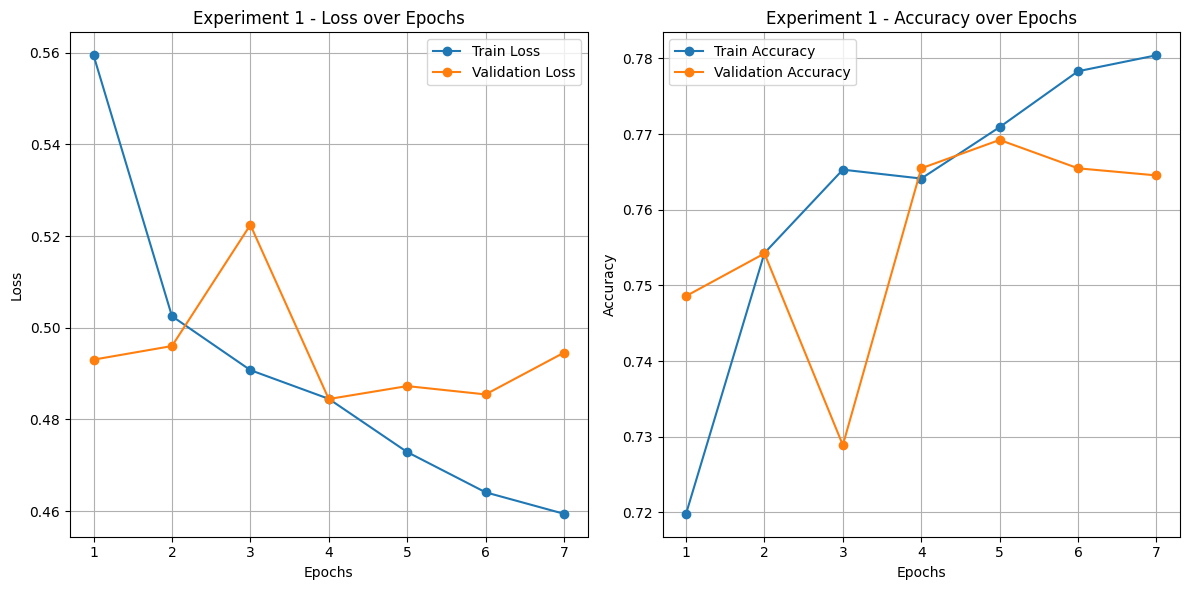

In [ ]:
# Model stepup
batch_size = 32
hidden_dim = 256
output_dim = 2
learning_rate = 0.0005
weight_decay=1e-5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


model = AveragePollingRNNModel(embedding_matrix, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()
model.to(device)


# Training the model with early stopping
num_epochs = 50
patience = 3
best_val_loss = float("inf")
early_stopping_count = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Early stopping if validation accuracy does not improve for 3 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_rnn_model.pth')
        early_stopping_count = 0
    else:
        early_stopping_count += 1
        if early_stopping_count >= patience:
            print("Early stopping as validation accuracy is not improving")
            break

draw_plot(train_losses, train_accuracies, val_losses, val_accuracies, "Experiment 1")

In [ ]:
# Evaluate on test set
model.load_state_dict(torch.load('best_rnn_model.pth'))
model.to(device)

test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

<ipython-input-19-0398ddbd8920>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_rnn_model.pth'))


Test Loss: 0.4955, Test Acc: 0.7420


## Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biL- STM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible.

In [ ]:
# BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, n_layers=2, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        # Embedding layer using pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=True,  # Freezing the embeddings
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if n_layers > 1 else 0
        )

        # Batch normalization and dropout
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

        # Final linear layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)

        # Create mask for padding
        mask = (x != self.embedding.padding_idx).unsqueeze(-1)

        # Pass through LSTM
        lstm_output, (hidden, cell) = self.lstm(embedded)

        # Apply mask
        lstm_output = lstm_output * mask

        # Average pooling
        summed = lstm_output.sum(dim=1)
        valid_counts = mask.sum(dim=1)
        valid_counts = valid_counts.clamp(min=1)
        mean_pooled = summed / valid_counts

        # Apply batch normalization and dropout
        output = self.batch_norm(mean_pooled)
        output = self.dropout(output)

        # Final linear layer
        output = self.fc(output)

        return output

In [ ]:
# BiGRU Model
class BiGRUModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, n_layers=2, dropout_rate=0.5):
        super(BiGRUModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        # Embedding layer using pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=True,
        )

        # Bidirectional GRU
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if n_layers > 1 else 0
        )

        # Batch normalization and dropout
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

        # Final linear layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)

        # Create mask for padding
        mask = (x != self.embedding.padding_idx).unsqueeze(-1)

        # Pass through GRU
        gru_output, hidden = self.gru(embedded)

        # Apply mask
        gru_output = gru_output * mask

        # Average pooling
        summed = gru_output.sum(dim=1)
        valid_counts = mask.sum(dim=1)
        valid_counts = valid_counts.clamp(min=1)
        mean_pooled = summed / valid_counts

        # Apply batch normalization and dropout
        output = self.batch_norm(mean_pooled)
        output = self.dropout(output)

        # Final linear layer
        output = self.fc(output)

        return output

In [ ]:
# Modified training setup for both models
def train_both_models():
    # Hyperparameters
    batch_size = 32
    hidden_dim = 256
    output_dim = 2
    learning_rate = 0.0005
    weight_decay = 1e-5
    n_layers = 2
    dropout_rate = 0.5

    # Data loaders (using existing code)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Initialize both models
    bilstm_model = BiLSTMModel(embedding_matrix, hidden_dim, output_dim, n_layers, dropout_rate)
    bigru_model = BiGRUModel(embedding_matrix, hidden_dim, output_dim, n_layers, dropout_rate)

    # Optimizers and schedulers for both models
    bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    bigru_optimizer = optim.Adam(bigru_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    bilstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        bilstm_optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    bigru_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        bigru_optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    criterion = nn.CrossEntropyLoss()

    # Move models to device
    bilstm_model.to(device)
    bigru_model.to(device)

    # Training loop parameters
    num_epochs = 50
    patience = 3

    # Training both models
    models = {
        'BiLSTM': (bilstm_model, bilstm_optimizer, bilstm_scheduler),
        'BiGRU': (bigru_model, bigru_optimizer, bigru_scheduler)
    }

    for model_name, (model, optimizer, scheduler) in models.items():
        print(f"\nTraining {model_name} model:")
        best_val_loss = float("inf")
        early_stopping_count = 0
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            scheduler.step(val_loss)

            print(f'Epoch [{epoch + 1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')
                early_stopping_count = 0
            else:
                early_stopping_count += 1

            if early_stopping_count >= patience:
                print("Early stopping as validation accuracy is not improving")
                break

        # Plot training curves
        draw_plot(
            train_losses,
            train_accuracies,
            val_losses,
            val_accuracies,
            f"Experiment 1 - {model_name}"
        )



Training BiLSTM model:
Epoch [1/50]
Train Loss: 0.5692, Train Acc: 0.7223
Val Loss: 0.7371, Val Acc: 0.6417
Epoch [2/50]
Train Loss: 0.4961, Train Acc: 0.7564
Val Loss: 0.4929, Val Acc: 0.7514
Epoch [3/50]
Train Loss: 0.4786, Train Acc: 0.7671
Val Loss: 0.4752, Val Acc: 0.7749
Epoch [4/50]
Train Loss: 0.4663, Train Acc: 0.7794
Val Loss: 0.4897, Val Acc: 0.7533
Epoch [5/50]
Train Loss: 0.4487, Train Acc: 0.7876
Val Loss: 0.5428, Val Acc: 0.7270
Epoch [6/50]
Train Loss: 0.4341, Train Acc: 0.7960
Val Loss: 0.5036, Val Acc: 0.7495
Early stopping as validation accuracy is not improving


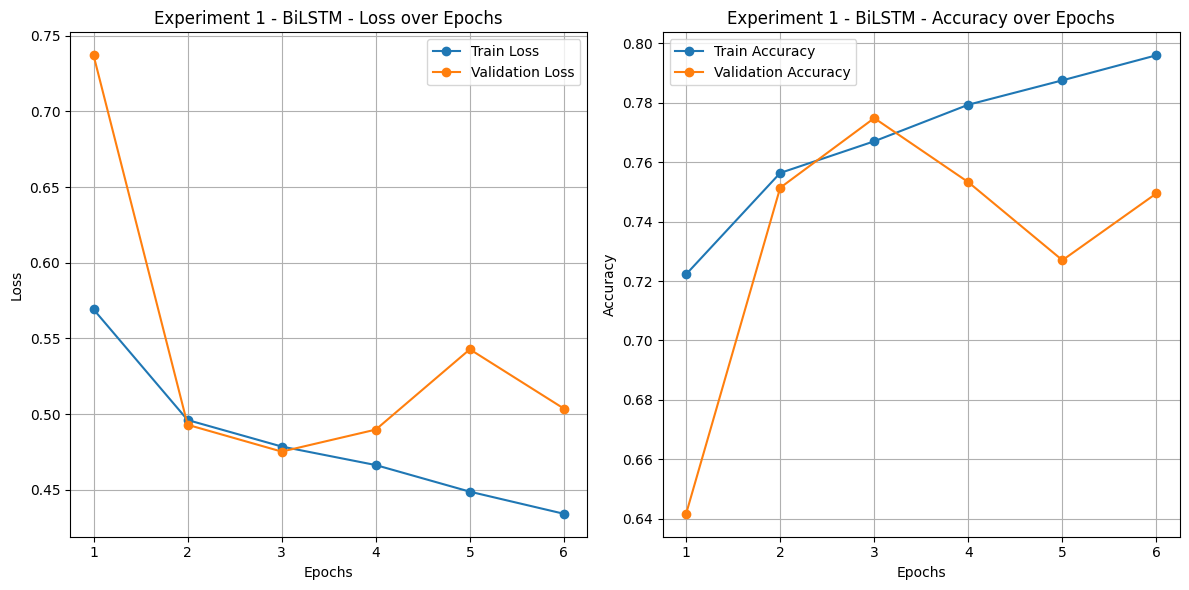


Training BiGRU model:
Epoch [1/50]
Train Loss: 0.5648, Train Acc: 0.7210
Val Loss: 0.5564, Val Acc: 0.7242
Epoch [2/50]
Train Loss: 0.4995, Train Acc: 0.7585
Val Loss: 0.4959, Val Acc: 0.7523
Epoch [3/50]
Train Loss: 0.4784, Train Acc: 0.7749
Val Loss: 0.4803, Val Acc: 0.7636
Epoch [4/50]
Train Loss: 0.4590, Train Acc: 0.7823
Val Loss: 0.4983, Val Acc: 0.7767
Epoch [5/50]
Train Loss: 0.4502, Train Acc: 0.7859
Val Loss: 0.4800, Val Acc: 0.7608
Epoch [6/50]
Train Loss: 0.4282, Train Acc: 0.7994
Val Loss: 0.4648, Val Acc: 0.7861
Epoch [7/50]
Train Loss: 0.4101, Train Acc: 0.8132
Val Loss: 0.4750, Val Acc: 0.7589
Epoch [8/50]
Train Loss: 0.4005, Train Acc: 0.8225
Val Loss: 0.4703, Val Acc: 0.7758
Epoch [9/50]
Train Loss: 0.3785, Train Acc: 0.8326
Val Loss: 0.4491, Val Acc: 0.7899
Epoch [10/50]
Train Loss: 0.3524, Train Acc: 0.8442
Val Loss: 0.5082, Val Acc: 0.7786
Epoch [11/50]
Train Loss: 0.3275, Train Acc: 0.8571
Val Loss: 0.5619, Val Acc: 0.7702
Epoch [12/50]
Train Loss: 0.3051, Train 

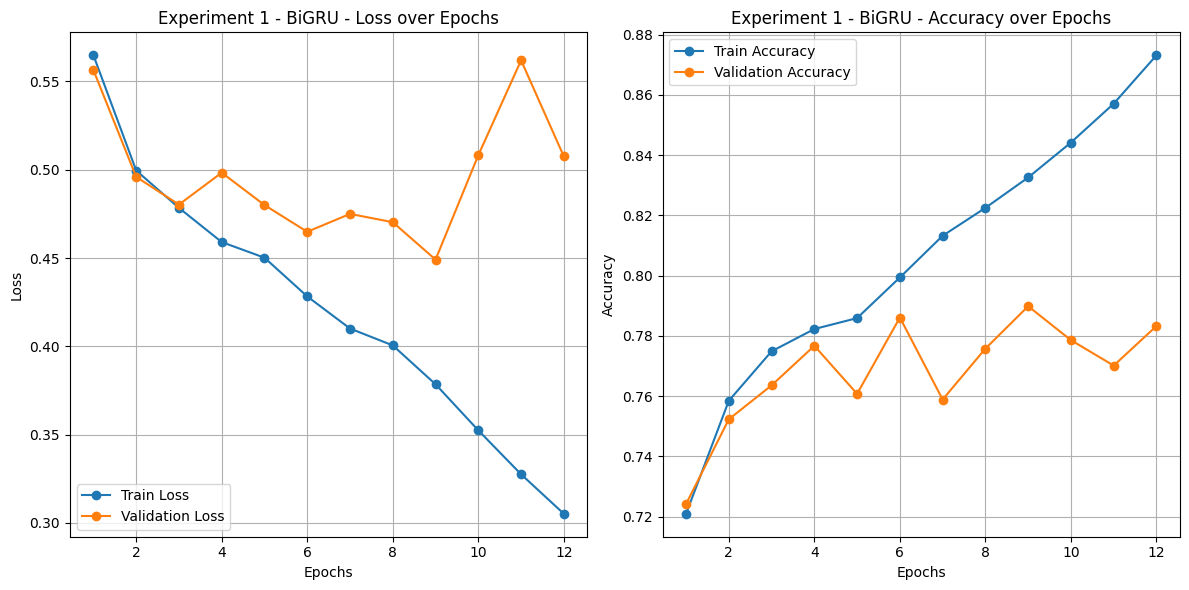

In [ ]:
# Run the training
if __name__ == "__main__":
    train_both_models()

In [ ]:
# Test set evaluation
def evaluate_test_set(model_name, model, test_loader, criterion):
    print(f"\nEvaluating {model_name} on test set:")
    model.load_state_dict(torch.load(f'best_{model_name.lower()}_model.pth'))
    model.to(device)
    model.eval()

    test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    return test_loss, test_acc

In [ ]:
# Evaluate on test set
#'BiLSTM' & 'BiGRU'
# First make sure we have the test data loader
test_loader = DataLoader(test_data, batch_size=32)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Initialize the models
bilstm_model = BiLSTMModel(embedding_matrix, hidden_dim=256, output_dim=2, n_layers=2, dropout_rate=0.5)
bigru_model = BiGRUModel(embedding_matrix, hidden_dim=256, output_dim=2, n_layers=2, dropout_rate=0.5)

# Evaluate BiLSTM
evaluate_test_set('BiLSTM', bilstm_model, test_loader, criterion)

# Evaluate BiGRU
evaluate_test_set('BiGRU', bigru_model, test_loader, criterion)


Evaluating BiLSTM on test set:


<ipython-input-25-116ac9257244>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_name.lower()}_model.pth'))


Test Loss: 0.4767, Test Acc: 0.7589

Evaluating BiGRU on test set:
Test Loss: 0.4468, Test Acc: 0.7842


(0.4467588614891557, 0.7842401500938087)